# Classification

## Import Libraries

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib as mpl

%matplotlib inline

## Get and View Data

In [3]:
mnist = fetch_openml('mnist_784', version = 1)

In [5]:
X, y = mnist['data'],mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [6]:
X = np.asarray(X)

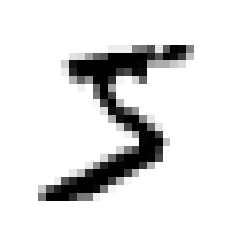

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()

In [8]:
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold=None):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], 'g--', label = "Recall")
    if threshold!=None:
        plt.axvline(threshold)
        index = (np.abs(thresholds - threshold)).argmin()
        plt.axhline(precisions[index])
        plt.axhline(recalls[index])
    plt.title('Precision and Recall vs Threshold Curves')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.grid()

In [20]:
def plot_precision_vs_recall(precisions, recalls, recall_val = None):
    plt.plot(recalls, precisions, "b--")
    plt.title('Precision vs Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    if recall_val!=None:
        plt.axvline(recall_val)
        index = (np.abs(recalls - recall_val)).argmin()
        plt.axhline(precisions[index])

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{"n_neighbors":list(np.linspace(1, 10, 10, dtype = 'int')), "weights":["uniform","distance"]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv = 5, scoring='accuracy', return_train_score=True, verbose=4)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.970) total time=   9.7s
[CV 2/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.971) total time=   9.3s
[CV 3/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.969) total time=   9.1s
[CV 4/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.969) total time=  10.1s
[CV 5/5] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.968) total time=  10.3s
[CV 1/5] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.970) total time=  11.0s
[CV 2/5] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.971) total time=  10.6s
[CV 3/5] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.969) total time=  10.8s
[CV 4/5] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.969) total time=  11.5s
[CV 5/5] END n_neighbors=1, weights=distance;, score=(train=1

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [53]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [59]:
from sklearn.metrics import accuracy_score

y_test_pred = grid_search.best_estimator_.predict(X_test)
print(f"Accuracy of the model: {accuracy_score(y_test, y_test_pred)}")

Accuracy of the model: 0.9714


In [60]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision of the model: {precision_score(y_test, y_test_pred, average = 'weighted')}")
print(f"Recall of the model: {recall_score(y_test, y_test_pred, average = 'weighted')}")

Precision of the model: 0.9715166824529755
Recall of the model: 0.9714


We've achieved the desired accuracy!

2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [45]:
class DataAugmentation():
    def __init__(self, num_pixels_to_shift = 1): # no *args or *kwargs
        self.num_pixels_to_shift = num_pixels_to_shift
    
    def shift(self, X, dir):
        X_img = X.reshape((-1, 28, 28))
        X_shift = np.zeros(shape = X_img.shape)
        num_pixels = self.num_pixels_to_shift
        if dir == 'up':
            X_shift[:,:-num_pixels,:] = X_img[:,num_pixels:,:]
        if dir == 'down':
            X_shift[:, num_pixels:, :] = X_img[:, :-num_pixels,:]
        if dir == 'left':
            X_shift[:,:,:-num_pixels] = X_img[:,:,num_pixels:]
        if dir == 'right':
            X_shift[:,:,num_pixels:] = X_img[:,:,:-num_pixels]
        return X_shift.reshape((-1, 784))

    def transform(self, X, y):
        X_left = self.shift(X,'left')
        X_right = self.shift(X,'right')
        X_up = self.shift(X,'up')
        X_down = self.shift(X,'down')
        
        X_aug = np.concatenate((X,X_left,X_right,X_up, X_down), axis = 0)
        y_aug = np.r_[y,y,y,y,y]
        return X_aug, y_aug

In [50]:
augment_data = DataAugmentation(2)
X_aug_train, y_aug_train = augment_data.transform(X_train, y_train)

Shuffle the data since now there's a pattern in the data which we would want to avoid.

In [52]:
idx = np.random.permutation(len(X_aug_train))
X_aug_train, y_aug_train = X_aug_train[idx], y_aug_train[idx]

In [54]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights = 'distance')
knn_clf.fit(X_aug_train, y_aug_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [61]:
y_test_pred = knn_clf.predict(X_test)
print(f"Accuracy of the model: {accuracy_score(y_test, y_test_pred)}")

Accuracy of the model: 0.9706


In [62]:
print(f"Precision of the augmented model: {precision_score(y_test, y_test_pred, average = 'weighted')}")
print(f"Recall of the augmented model: {recall_score(y_test, y_test_pred, average = 'weighted')}")

Precision of the augmented model: 0.9709064779080727
Recall of the augmented model: 0.9706


3. Tackle the Titanic dataset. A great place to start is on Kaggle.

In [7]:
import os
os.environ['KAGGLE_USERNAME'] = 'pratiksangh'
os.environ['KAGGLE_KEY'] = '6541dd1b65a4da0f34d6543acd72b548'
!kaggle competitions download -c titanic


  0%|          | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████| 34.1k/34.1k [00:00<00:00, 4.36MB/s]


### Extract and remove the zipped file

In [3]:
import zipfile

with zipfile.ZipFile('titanic.zip','r') as zip_ref:
    zip_ref.extractall('./datasets/titanic')

if os.path.exists('./datasets/titanic/train.csv'):
    os.remove('titanic.zip')

### Read Data

In [1]:
import pandas as pd

train_dataset = pd.read_csv('./datasets/titanic/train.csv')
test_dataset = pd.read_csv('./datasets/titanic/test.csv')

### Transform and Prepare Data

In [2]:
corr_matrix = train_dataset.corr()
corr_matrix['Survived'].sort_values(ascending = False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [3]:
from sklearn.impute import SimpleImputer

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
dataset_num = train_dataset.drop(["PassengerId","Survived","Pclass","Name","Sex", "SibSp","Parch","Ticket", "Cabin", "Embarked"], axis = 1)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())
])

In [8]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one_hot_encoder', OneHotEncoder())
])

In [9]:
from sklearn.compose import ColumnTransformer

num_attribs = list(dataset_num.columns)
cat_attribs = ["Pclass","Sex", "SibSp","Parch", "Embarked"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

dataset = pd.concat([train_dataset, test_dataset])
dataset_prepared = full_pipeline.fit_transform(dataset)
train_dataset_prepared = full_pipeline.transform(train_dataset)

In [10]:
test_dataset_prepared = full_pipeline.transform(test_dataset)

In [11]:
train_labels = train_dataset['Survived'].copy()

### Read the Test Labels

In [13]:
test_labels = pd.read_csv('./datasets/titanic/gender_submission.csv')

### Trying out different Models

In [14]:
# 1. Support Vector Classifier
from sklearn.svm import SVC

# 2. Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# 3. K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

In [15]:
# Getting the accuracy score metric to decide which model to choose.
from sklearn.metrics import accuracy_score

In [16]:
svc_clf = SVC()
svc_clf.fit(train_dataset_prepared, train_labels)

SVC()

In [22]:
test_labels_pred = svc_clf.predict(test_dataset_prepared)
print(f'Accuracy over test set: {accuracy_score(test_labels["Survived"], test_labels_pred)}')

Accuracy over test set: 0.9354066985645934


In [23]:
forest_clf = RandomForestClassifier()
forest_clf.fit(train_dataset_prepared, train_labels)

RandomForestClassifier()

In [24]:
test_labels_pred = forest_clf.predict(test_dataset_prepared)
print(f'Accuracy over test set: {accuracy_score(test_labels["Survived"], test_labels_pred)}')

Accuracy over test set: 0.80622009569378


In [25]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_dataset_prepared, train_labels)

KNeighborsClassifier()

In [26]:
test_labels_pred = knn_clf.predict(test_dataset_prepared)
print(f'Accuracy over test set: {accuracy_score(test_labels["Survived"], test_labels_pred)}')

Accuracy over test set: 0.8564593301435407


So it appears that SVC performs the best for the given dataset! Lets tune the hyperparameters to see if it improves the performance.

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"C":[1e-2,1e-1,1,1e1,1e2],"kernel":["linear"],"decision_function_shape":['ovo','ovr']},
    {"C":[1e-2,1e-1,1,1e1,1e2],"kernel":["poly", "rbf","sigmoid"],"gamma":["scale", "auto"],"decision_function_shape":['ovo','ovr']}
]

svc_clf = SVC()
grid_search = GridSearchCV(svc_clf, param_grid, cv = 5, scoring='accuracy', return_train_score=True, verbose=4)

grid_search.fit(train_dataset_prepared, train_labels)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.782, test=0.793) total time=   0.0s
[CV 2/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.785, test=0.803) total time=   0.0s
[CV 3/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.790, test=0.787) total time=   0.0s
[CV 4/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.795, test=0.753) total time=   0.0s
[CV 5/5] END C=0.01, decision_function_shape=ovo, kernel=linear;, score=(train=0.787, test=0.787) total time=   0.0s
[CV 1/5] END C=0.01, decision_function_shape=ovr, kernel=linear;, score=(train=0.782, test=0.793) total time=   0.0s
[CV 2/5] END C=0.01, decision_function_shape=ovr, kernel=linear;, score=(train=0.785, test=0.803) total time=   0.0s
[CV 3/5] END C=0.01, decision_function_shape=ovr, kernel=linear;, score=(train=0.790, test=0.787) total time=   0.0s
[C

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10.0, 100.0],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10.0, 100.0],
                          'decision_function_shape': ['ovo', 'ovr'],
                          'gamma': ['scale', 'auto'],
                          'kernel': ['poly', 'rbf', 'sigmoid']}],
             return_train_score=True, scoring='accuracy', verbose=4)

In [30]:
grid_search.best_params_

{'C': 10.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'}

In [31]:
test_labels_pred = grid_search.best_estimator_.predict(test_dataset_prepared)
print(f'Accuracy over test set: {accuracy_score(test_labels["Survived"], test_labels_pred)}')

Accuracy over test set: 0.9354066985645934


So seems like we're at the minima for support vector classifier. But this was a good exercise anyway to check if there existed further scope for optimisation. As a last check, let us compute the precision, recall and f1 score for the model.

In [35]:
from sklearn.metrics import precision_score, recall_score,f1_score

print(f"Precision of the model: {precision_score(test_labels['Survived'], test_labels_pred)}")
print(f"Recall of the model: {recall_score(test_labels['Survived'], test_labels_pred)}")
print(f"F1 Score of the model: {f1_score(test_labels['Survived'], test_labels_pred)}")

Precision of the model: 0.9432624113475178
Recall of the model: 0.875
F1 Score of the model: 0.9078498293515359


Seems decent enough!

In [36]:
df_submission = pd.DataFrame({'PassengerId':test_labels["PassengerId"].to_list(), 'Survived':test_labels_pred})
df_submission.to_csv('./datasets/titanic/submission.csv', index = False)

In [37]:
!kaggle competitions submit -c titanic -f ./datasets/titanic/submission.csv -m "Model: `SVC Model`, Params: `{'C': 10.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'}`,Accuracy: 0.9354066985645934, Precision: 0.9432624113475178, Recall: 0.875, F1 Score: 0.9078498293515359"

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|██████████| 3.18k/3.18k [00:00<00:00, 20.9kB/s]
100%|██████████| 3.18k/3.18k [00:05<00:00, 634B/s]  
